## Facebook data Analysis

### Libraries 

In [1]:
import numpy as np
import networkx as nx
import gzip
import matplotlib.pyplot as plt
import matplotlib.colors as c
import random
import math
import seaborn as sns
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import networkx.readwrite.gexf as gexf
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.readwrite import json_graph
import json
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import GraphRenderer,Range1d, HoverTool, StaticLayoutProvider, Circle, Plot
from bokeh.models.graphs import NodesOnly, from_networkx
from bokeh.palettes import magma, Reds

### Draw of greedy Communities

A community is a set of nodes with more links among them than to other parts of the network. Thus communities form separated groups of nodes, who share more edges between themselves than with other groups. 

The `draw_greedy_communities` algorithm gives a color to each community in the network, thus we can see each member of the group even if the layout of the graph isn't already representing it that way. To implement this method, we used a method called `greedy_modularity_communities` which was imported from the networkx.algorithms module. This algorithm unfortunately only gives a fronzenset of the groups. (The set type is mutable whereas the frozenset type is immutable and hashable.) That's why the `draw_greedy_communities` algorithm takes this groups in the frozenset, and gives independent colors to it. It then draws the network using `networkx.draw` method.

In [13]:
def draw_greedy_communities(g, layout, title, color):
    nodeList = tuple(g.nodes())
    pos = layout
    set_nodes = greedy_modularity_communities(g)
    list_nodes = [list(x) for x in set_nodes]
    node_color = [0]*len(g.nodes())
    n = -1
    count = 0
    print("There are", len(list_nodes), "groups!")
    for group in list_nodes[:]:
        n += 1
        for i in group[:]:
            count+=1
            node_color[i] = n
    node_color_tuple = node_color
    nx.draw(g, with_labels= False, pos = pos, node_size=100, nodelist = nodeList,
            node_color= node_color_tuple, cmap=color)
    plt.title(title)

### Imported Files from SNAP

**Data Source: ** https://snap.stanford.edu/data/egonets-Facebook.html

The data used in this project is from Facebook. The nodes represent the profiles of the participants, circles which are friends lists, and ego networks which are the networks for a particular user.

Because of the new law on data privacy (GDPR), the features of the profiles of the participants have been anonymized, thus we can only get a number for a particular feature, which will still help us group individuals by their respective features.

The files that were imported are the following:

- **facebook.tar.gz** : The anonymized facebook networks of 10 different participants.

- **facebook_combined.txt.gz** : The edges of all the ego networks combined.

Also, the _facebook.tar.gz_ file contains this sub files, each for the 10 different nodeId:

- **nodeId.edges** : The edges in the ego network for the node 'nodeId'. Edges are undirected for facebook, and directed (a follows b) for twitter and gplus. The 'ego' node does not appear, but it is assumed that they follow every node id that appears in this file.

- **nodeId.circles** : The set of circles for the ego node. Each line contains one circle, consisting of a series of node ids. The first entry in each line is the name of the circle.

- **nodeId.feat** : The features for each of the nodes that appears in the edge file.

- **nodeId.egofeat** : The features for the ego user.

- **nodeId.featnames** : The names of each of the feature dimensions. Features are '1' if the user has this property in their profile, and '0' otherwise. This file has been anonymized for facebook users, since the names of the features would reveal private data.

To read these files, you can use **PeaZip** to retrieve the data, such that you can read it and use it on Python. The data have already been put in the Binder, so no need to do this step.

In [14]:
edges107 = open('Data/facebook/107.edges', 'r')
circles107 = open("Data/facebook/107.circles", 'r')
featnames107 = open("Data/facebook/107.featnames", 'r')
feat107 = open("Data/facebook/107.feat", 'r')
egofeat107 = open("Data/facebook/107.egofeat", 'r')
f_comb = open('Data/facebook_combined.txt', 'r')

The two following methods are helpful to compute a graph such that the nodeId's of the network are mapped to indices for a list. This way the `draw_greedy_communities` method works well. 

In [15]:
def create_graph_edges_with_range_indices_and_counter(g, file, counter):
    #Create "count" edges
    G_tmp = nx.Graph()
    count = counter
    for string in file:
        if(count == 0):
            print("We computed the", counter,"edges")
            break;
        edge = string.split(" ")
        edge[1] = edge[1][:-1]
        G_tmp.add_edge(int(edge[0]), int(edge[1]))
        count = count - 1
    
    #Create nodes
    nodes = list(G_tmp.nodes())
    indices = list(range(len(nodes)))
    dict_map = dict(zip(nodes, indices))
    G = nx.Graph()
    G.add_nodes_from(dict_map.keys())
    
    #Create edges with indices of range(0, len(g.nodes))
    for edger in G_tmp.edges():
        g.add_edge(dict_map.get(edger[0]), dict_map.get(edger[1]))
    
def create_graph_edges_with_range_indices(g, file):
    #Create edges
    for string in file:
        edge = string.split(" ")
        edge[1] = edge[1][:-1]
        g.add_edge(int(edge[0]), int(edge[1]))
        
    #Create nodes
    nodes = list(g.nodes())
    indices = list(range(len(nodes)))
    dict_map = dict(zip(nodes, indices))
    G = nx.Graph()
    G.add_nodes_from(dict_map.keys())
    
    #Create edges with indices of range(0, len(g.nodes))
    G_1 = nx.Graph()
    for edge in g.edges():
        G_1.add_edge(dict_map.get(edge[0]), dict_map.get(edge[1]))
    g = G_1
    

We computed the 6000 edges


Text(0.5,1,'Fruchterman_reingold_layout')

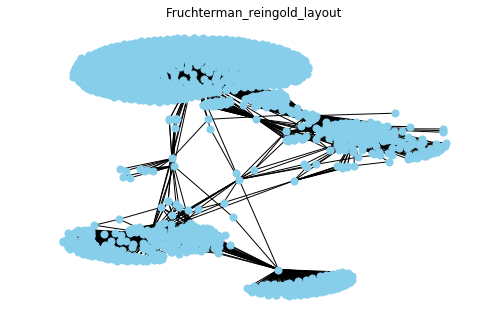

In [16]:
G_comb = nx.Graph()
create_graph_edges_with_range_indices_and_counter(G_comb, f_comb, 6000)
G_comb_pos = nx.fruchterman_reingold_layout(G_comb)
nx.draw(G_comb, with_labels=False, node_size=50, node_color="skyblue", pos = G_comb_pos)
plt.title("Fruchterman_reingold_layout")

Below is the same graph drawn by communities.

There are 10 groups!


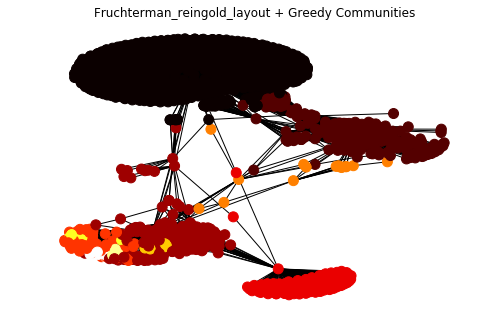

In [17]:
draw_greedy_communities(g = G_comb, layout=G_comb_pos, title= "Fruchterman_reingold_layout + Greedy Communities", color=plt.cm.hot)

## Bokeh

Let's try and plot the above graph by using the library of Bokeh.

The code below is helpful to draw the network in Bokeh such that the positions of the nodes aren't to clos to each other. We thus see a better graph.

In [7]:
for a in G_comb_pos.values():
    a[0] = a[0]*100
    a[1] = a[1]*100

In [8]:
#Bokeh
plot = Plot(plot_height = 1000, 
           plot_width = 1000,
           x_range=Range1d(-100, 100), 
           y_range=Range1d(-100, 100))
plot.title.text = "Bokeh"
G_Bokeh = GraphRenderer()
nod = G_Bokeh.node_renderer
edg = G_Bokeh.edge_renderer
node_indices = list(G_comb.nodes())

nod.data_source.add(node_indices, 'index')
nod.glyph = Circle(size=20)


edg.data_source.data = dict(
    start=list(G_comb.edges())[:][0],
    end=list(G_comb.edges())[:][1])

index_hover = [
    ("name", "@index")
]

plot.add_tools(HoverTool(tooltips = index_hover))

graph_layout = G_comb_pos
G_Bokeh.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

G_Bokeh.inspection_policy = NodesOnly()
plot.renderers.append(G_Bokeh)
output_notebook()
show(plot)

Loading BokehJS ...

## Facebook Ego Networks

Now that we have a big view of how our SNAP network looks like, let's take these above individual communities and view them independently. In our case we will first analyse the **nodeID** == 0:

1034


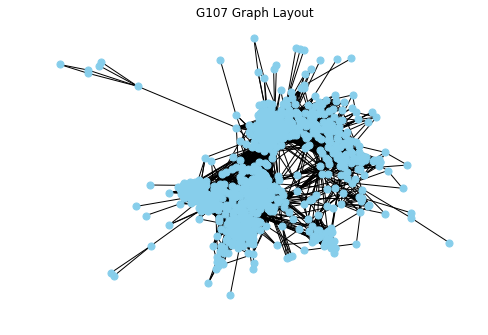

In [9]:
edges107 = open('Data/facebook/107.edges', 'r')

G107 = nx.Graph()
create_graph_edges_with_range_indices(G107, edges107)
G107_pos = nx.fruchterman_reingold_layout(G107)
nx.draw(G107, with_labels=False, node_size=50, node_color="skyblue", pos = G107_pos)
plt.title("G107 Graph Layout")
print(len(G107.nodes))

Now let's identify the circles by reading the `107.circles` file. We will thus create a dictionary that has as keys he name circle _IDnode_ and as values the _IDnodes_ that are in this circle.

In [10]:
circles107 = open("Data/facebook/107.circles", 'r')

def read_circles_file(f):
    circles = []
    circles_indexes = []
    circles_list = []
    dic = {}
    for s in f:
        a = s.split("\t")
        a[-1] = a[-1][:-1]
        circles.append(a)
    for tupl in circles:
        circles_indexes.append(tupl[0])
        circles_list.append(tupl[1:])
    return dict(zip(circles_indexes, circles_list))

dict_cycles = read_circles_file(circles107)

Let's now draw our graph by giving a color to each node. The problem now is that the nodes in the circles can be repeated, thus one node could have 2 colors. What we did is remove the duplicate nodes, and keep them in only one circle.

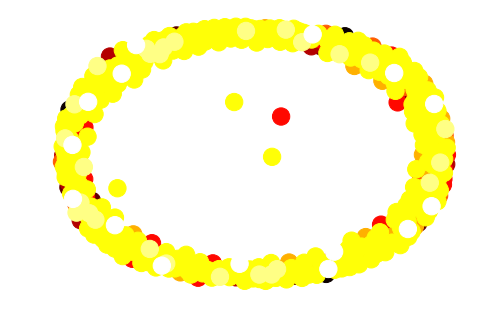

In [36]:
import matplotlib.colors

G_cycle = nx.Graph()
cycle_list = list(dict_cycles.values())

for ls in cycle_list:
    G_cycle.add_nodes_from(ls)

def draw_cycles(G):
    color_map = []
    n=0
    count = len(G.nodes())
    for ls in cycle_list:
        for i in ls:
            if (count == 0):
                break;
            count-=1
            color_map.append(6*n)
        n = n+1
    nx.draw(G, node_color = color_map, cmap = plt.cm.hot, pos = nx.fruchterman_reingold_layout(G))
    plt.show()

draw_cycles(G_cycle)